In [126]:
import math
import numpy as np
import math
from datasets import load_dataset

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import re
import json
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import random

import ast

In [127]:
#silverdataset = pd.read_csv('datasets/silver.csv')
silverdataset = pd.read_csv('datasets/gold.csv').iloc[:150]
golddataset = pd.read_csv('datasets/gold.csv').iloc[150:300]

text_gold = pd.read_csv('datasets/wikipedia_text_stats_grouped_gold_links.csv').iloc[:150]
text_silver = pd.read_csv('datasets/wikipedia_text_stats_grouped_gold_links.csv').iloc[150:300]


In [128]:
def heuristic_from_text(column):
    nations = set(pd.read_csv('datasets/national_adjectives.csv')["Country"])
    national_adjectives = set(pd.read_csv('datasets/national_adjectives.csv')["Adjective"])
    
    column['new_description'] = column.apply(lambda elem: set(elem.iloc[0].split()), axis=1)
    column['length_description_intersection'] = column['new_description'].apply(lambda elem:  len(elem.intersection(national_adjectives)))
    
    column['nations'] = column['new_description'].apply(lambda elem:  len(elem.intersection(nations)))

    return column['length_description_intersection'], column['nations']

In [129]:
# text_silver e text_gold preprocessing
silver_text_dataset = pd.DataFrame(text_silver)
silver_text_dataset = silver_text_dataset.drop(columns=["engtext"])
gold_text_dataset = pd.DataFrame(text_gold)
gold_text_dataset = gold_text_dataset.drop(columns=["engtext"])

array_augmentation = 1
assert(array_augmentation == 1)

#Compute size of distribution array which equals to number of wikipedia links per item. (There is one per language)
compute_len = lambda x: len(array_augmentation*ast.literal_eval(x)) if type(ast.literal_eval(x)) is not float else None
silver_text_dataset["len"] = silver_text_dataset["distribution"].apply(compute_len)
gold_text_dataset["len"] = gold_text_dataset["distribution"].apply(compute_len)

#Compute sum over the distribution array
compute_sum = lambda x: sum(array_augmentation*ast.literal_eval(x)) if type(ast.literal_eval(x)) is not float else None
silver_text_dataset["sum_over_texts"] = silver_text_dataset["distribution"].apply(compute_sum)
gold_text_dataset["sum_over_texts"] = gold_text_dataset["distribution"].apply(compute_sum)

silver_text_dataset = silver_text_dataset.drop(columns="distribution")
gold_text_dataset = gold_text_dataset.drop(columns="distribution")

n_quantili = 2

# avg, std, len are categorized based on quantili
avg_bins_edges = pd.qcut(silver_text_dataset['avg'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali
std_bins_edges = pd.qcut(silver_text_dataset['std'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali
len_bins_edges = pd.qcut(silver_text_dataset['len'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali
sum_bins_edges = pd.qcut(silver_text_dataset['sum_over_texts'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali

silver_text_dataset['avg_bins'] = pd.cut(silver_text_dataset['avg'], bins=avg_bins_edges, include_lowest=True)
silver_text_dataset['std_bins'] = pd.cut(silver_text_dataset['std'], bins=std_bins_edges, include_lowest=True)
silver_text_dataset['len_bins'] = pd.cut(silver_text_dataset['len'], bins=len_bins_edges, include_lowest=True)
silver_text_dataset['texts_sum'] = pd.cut(silver_text_dataset['sum_over_texts'], bins=sum_bins_edges, include_lowest=True)
silver_text_dataset.dropna(subset=["len_bins"], inplace=True)
silver_text_dataset.dropna(subset=["texts_sum"], inplace=True)

gold_text_dataset['avg_bins'] = pd.cut(gold_text_dataset['avg'], bins=avg_bins_edges, include_lowest=True)
gold_text_dataset['std_bins'] = pd.cut(gold_text_dataset['std'], bins=std_bins_edges, include_lowest=True)
gold_text_dataset['len_bins'] = pd.cut(gold_text_dataset['len'], bins=len_bins_edges, include_lowest=True)
gold_text_dataset['texts_sum'] = pd.cut(gold_text_dataset['sum_over_texts'], bins=sum_bins_edges, include_lowest=True)
gold_text_dataset.dropna(subset=["len_bins"], inplace=True)
gold_text_dataset.dropna(subset=["texts_sum"], inplace=True)

#avg, std, len are dropped
silver_text_dataset = silver_text_dataset.drop(columns=["avg", "std", "len", "sum_over_texts"])
gold_text_dataset = gold_text_dataset.drop(columns=["avg", "std", "len", "sum_over_texts"])

In [130]:
#Now we want to combine [silverdataset, silver_text_dataset] and [goldataset, gold_text_dataset] with respect to the key <entity>
silver_merged = pd.merge(silverdataset, silver_text_dataset, left_on='item', right_on='entity')
gold_merged = pd.merge(golddataset, gold_text_dataset, left_on='item', right_on='entity')

silver_merged = silver_merged.drop(columns="entity")
gold_merged = gold_merged.drop(columns="entity") 

print(silver_merged.columns)

Index(['item', 'name', 'description', 'type', 'category', 'subcategory',
       'label', 'avg_bins', 'std_bins', 'len_bins', 'texts_sum'],
      dtype='object')


In [131]:
#ALTRO PREPROCESSING
# Rimuovo colonne non utili dal training set e dall'evaluation test
dataset = training_data.drop(columns=["item", "name", "description"])
evaluation_dataset = evaluation_data.drop(columns=["item", "name", "description"])

# Heuristic su 'description'
train_desc = pd.DataFrame(training_data["description"])
dataset['h_description'], dataset['nations'] = heuristic_from_text(train_desc)

# Stesso preprocessing per l'evaluation set
eval_desc = pd.DataFrame(evaluation_data["description"])
evaluation_dataset['h_description'], evaluation_dataset['nations'] = heuristic_from_text(eval_desc)

In [132]:
training_data = silver_merged
evaluation_data = gold_merged

In [133]:
# Colonne categoriali da codificare
#categorical_columns = ["h_description", "nations", "type", "category", "subcategory", "label", "avg_bins", "std_bins", "len_bins", "texts_sum"]
categorical_columns = dataset.columns

print(categorical_columns)

# Inizializza OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(dataset[categorical_columns])

# Trasforma separatamente training e evaluation
encoded_train = encoder.transform(dataset[categorical_columns])
encoded_eval = encoder.transform(evaluation_dataset[categorical_columns])

# Crea DataFrame dalle codifiche
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns), index=dataset.index)
encoded_eval_df = pd.DataFrame(encoded_eval, columns=encoder.get_feature_names_out(categorical_columns), index=evaluation_dataset.index)
# Rimuovi le colonne originali e aggiungi quelle codificate
dataset = dataset.drop(columns=categorical_columns)
dataset = pd.concat([dataset, encoded_train_df], axis=1)

evaluation_dataset = evaluation_dataset.drop(columns=categorical_columns)
evaluation_dataset = pd.concat([evaluation_dataset, encoded_eval_df], axis=1)

# Seleziono feature e target
labels = ['label_cultural agnostic', 'label_cultural exclusive', 'label_cultural representative']
X_train = dataset.drop(columns=labels)
y_train = dataset[labels]
X_test = evaluation_dataset.drop(columns=labels)
y_test = evaluation_dataset[labels]

rf_model = RandomForestClassifier(n_estimators=1000, criterion='gini', random_state=42)
rf_model.fit(X_train, y_train)

# Predizioni sul test set
y_pred = rf_model.predict(X_test)

# Accuratezza
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"Accuratezza del modello: {accuracy:.2f}")
print(f"f1 score del modello: {f1:.2f}")

Index(['type', 'category', 'subcategory', 'label', 'avg_bins', 'std_bins',
       'len_bins', 'texts_sum', 'h_description', 'nations'],
      dtype='object')
Accuratezza del modello: 0.46
f1 score del modello: 0.49


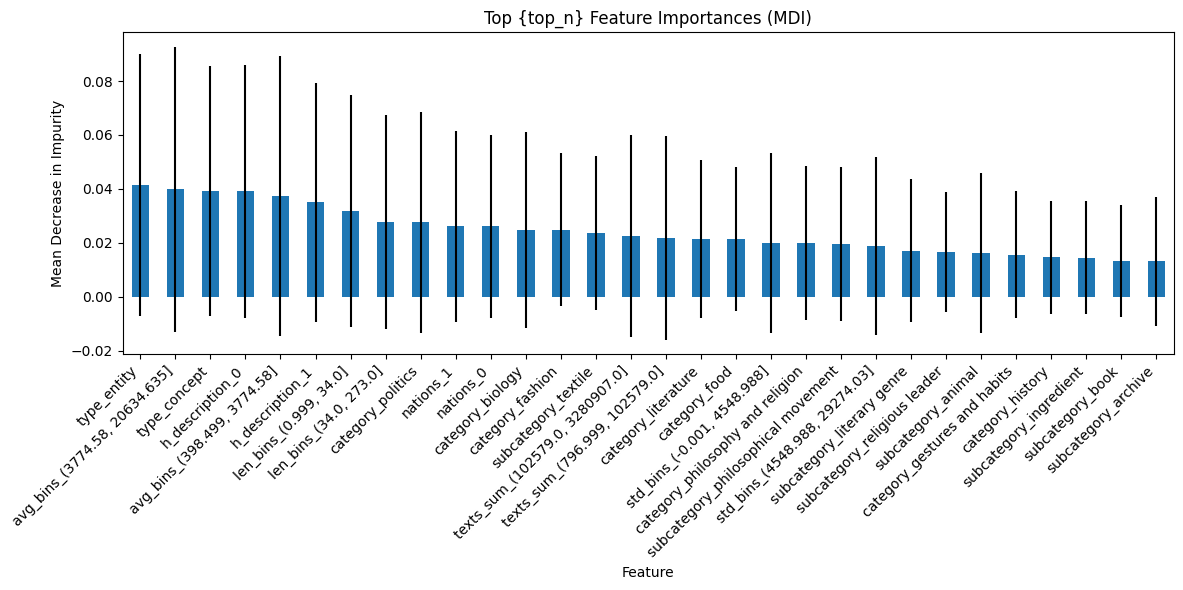

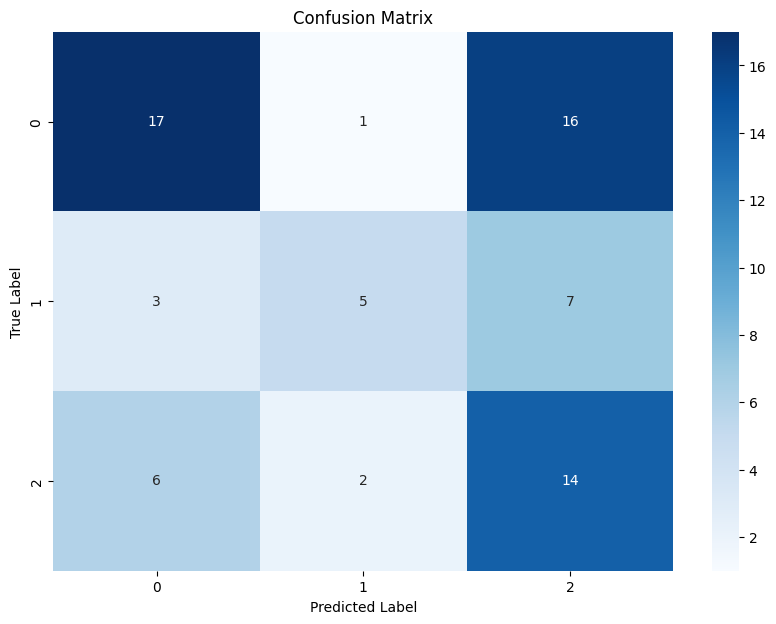

In [134]:
#ANALITICS

# Crea i nomi delle feature (se non li hai già)
feature_names = X_train.columns.tolist()

# Calcola le importanze medie e deviazione standard tra tutti gli alberi
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

# Serie ordinata con le feature
forest_importances = pd.Series(importances, index=feature_names)

# Ordina e prendi le top 20
top_n = 30
top_features = forest_importances.sort_values(ascending=False).head(top_n)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
top_features.plot.bar(yerr=std[[feature_names.index(f) for f in top_features.index]], ax=ax)
ax.set_title("Top {top_n} Feature Importances (MDI)")
ax.set_ylabel("Mean Decrease in Impurity")
ax.set_xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()